### Notebook to assess lagged changes in precip category in TC output, binned according to a 2D variable.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/18/23

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
# from mask_tc_track import mask_tc_track
from precip_class import precip_class
from memory_usage import memory_usage
from read_functions import *

#### Main settings

In [2]:
# Index variable (2D; independent var)
ivar_select = 'pw'
# options (requiring 2D info): pw, rain, lwacre
# options (requiring 3D info): vmf

# Number of sample time steps
nt=200 # will be chopped down to max available
nt=24#6

#### Additional settings and directories

In [3]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# Tests to read and compare
# tests = ['crfon','ncrf']
# if storm == 'haiyan':
#     tests = ['ctl','ncrf36h']
# elif storm == 'maria':
#     # tests = ['ctl','ncrf36h']
#     tests = ['ctl','ncrf48h']
# tests = ['ctl']
test_str='ctl'

time_neglect=12 # time steps from start to neglect

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
nmem = 2
enstag = str(nmem)

In [4]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+test_str+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=np.min([nt,nt_data-time_neglect])

# Get WRF file list
# datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
# wrffiles, lat, lon = get_wrf_filelist(datdir)

#### Main loops and compositing

In [5]:
memory_usage()

Total:      134.32 GB
Avail:      127.65 GB
Used:       2.71 GB
Free:       128.31 GB
Active:     2.95 GB
Inactive:   1.07 GB


In [6]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
dims = (nmem, nt, nx1, nx2)
strat_all  = np.ma.zeros(dims)
cwv_all    = np.ma.zeros(dims)
lwacre_all = np.ma.zeros(dims)

# This has been tested for corresponding time steps:
#   t0=37,1 are the first divergent time steps in CTL,NCRF
#   t0=25,1 are the first divergent time steps in NCRF,CRFON
# if test_str == 'ctl':
#     if tests[1] == 'ncrf36h':
#         t0=36
#     elif tests[1] == 'ncrf48h':
#         t0=48
# elif test_str == 'ncrf36h':
#     t0=t0_test
# elif test_str == 'ncrf48h':
#     t0=t0_test
# elif test_str == 'crfon':
#     t0=0
t0=time_neglect # neglect the first 12 time steps
t1=t0+nt

# t0+=1 # add one time step since NCRF(t=0) = CTL
# t1 = t0+nt

print('Running test: ',test_str)

# Loop over ensemble members

for imemb in range(nmem):

    print('Running imemb: ',memb_all[imemb])

    datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
    print(datdir)

    # Stratiform index
    q_int = read_qcloud(datdir,t0,t1) # mm
    strat_all[imemb,:,:,:] = precip_class(q_int)

    # LWACRE
    lwacre_all[imemb,:,:,:] = read_lwacre(datdir,t0,t1) # W/m2

    # CWV
    varname='PW'
    cwv_all[imemb,:,:,:] = var_read_2d(datdir,varname,t0,t1) # mm
    # ddtq = np.gradient(cwv, axis=0) # mm/hr

Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/


In [7]:
memory_usage()

Total:      134.32 GB
Avail:      125.62 GB
Used:       4.49 GB
Free:       123.71 GB
Active:     4.7 GB
Inactive:   3.89 GB


#### Index aka Bin variable

In [8]:
# Variable settings

# PW
if ivar_select == 'pw':
    fmin=35;fmax=80 # mm
    step=2 # mm
    bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
# Rainfall rate
elif ivar_select == 'rain':
    # bins=10.**(np.arange(1,8,0.3)-4)
    bins=10.**(np.arange(0,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'
# LW-ACRE
elif ivar_select == 'lwacre':
    fmin=-50; fmax=200 # W/m2
    step=5
    bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m**2]'
    log_x='linear'
# Vertical mass flux
elif ivar_select == 'vmf':
    bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'
# Theta-e (equivalent potential temperature)
elif ivar_select == 'th_e':
    fmin=315; fmax=365 # K
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel=r'$\theta_e$ [K]'
    log_x='linear'

nbins = np.size(bins)

# Create axis of bin center-points for plotting
bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

In [9]:
# Loop for reading INDEX aka BIN variable

ivar_all = np.ma.zeros(dims)

# This has been tested for corresponding time steps:
#   t0=37,1 are the first divergent time steps in CTL,NCRF
#   t0=25,1 are the first divergent time steps in NCRF,CRFON
# if test_str == 'ctl':
#     if tests[1] == 'ncrf36h':
#         t0=36
#     elif tests[1] == 'ncrf48h':
#         t0=48
# elif test_str == 'ncrf36h':
#     t0=t0_test
# elif test_str == 'ncrf48h':
#     t0=t0_test
# elif test_str == 'crfon':
#     t0=0

# t0+=1 # add one time step since NCRF(t=0) = CTL
# t1 = t0+nt

# Loop over ensemble members

for imemb in range(nmem):

    # print('Running imemb: ',memb_all[imemb])

    datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
    datdir3d = datdir #+'v2/'
    # print(datdir)

    # Index AKA Bin variable ("ivar")

    # PW
    if ivar_select == 'pw':
        varname = ivar_select.upper()
        ivar_all[imemb,:,:,:] = var_read_2d(datdir,varname,t0,t1)
    # Rainfall rate
    elif ivar_select == 'rain':
        varname = 'rainrate'
        rain = var_read_2d(datdir,varname,t0,t1) # mm/hr
        ivar_all[imemb,:,:,:] = rain # mm/hr
    # LW-ACRE
    elif ivar_select == 'lwacre':
        binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
        ivar_all[imemb,:,:,:] = binfil.variables['LWUPB'][t0:t1,:,:,:] # W/m2
        binfil.close()

In [10]:
memory_usage()

Total:      134.32 GB
Avail:      125.24 GB
Used:       4.87 GB
Free:       123.33 GB
Active:     5.25 GB
Inactive:   3.72 GB


#### Conduct compositing

In [31]:
# Loop and composite variables

strat_binned=np.ma.zeros((nbins-1,6)) # Bin count: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
lwacre_binned=np.ma.zeros((nbins-1))
lwacre_strat=np.ma.zeros((nbins-1,6)) # LWACRE in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
cwv_strat=np.ma.zeros((nbins-1,6)) # CWV in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil

# Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
ravelled = np.ravel(ivar_all)
for ibin in range(nbins-1):

    # indices = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1])).nonzero()
    indices = ((ravelled >= bins[ibin]) & (ravelled < bins[ibin+1])).nonzero()

    if indices[0].shape[0] > 3:
        lwacre_binned[ibin]  = np.mean(lwacre_all[indices], axis=0, dtype=np.float64)
    else:
        lwacre_binned[ibin]= np.nan
        strat_binned[ibin,:] = np.nan
        lwacre_strat[ibin,:] = np.nan
        cwv_strat[ibin,:] = np.nan
        continue

    for kstrat in range(0,6):
        # indices_strat = (strat_all[indices[0],indices[1],indices[2],indices[3]] == kstrat).nonzero()
        # indices_shaped = np.unravel_index(indices_strat[0],dims[1:])

        # Bin the 2D var by rain class
        indices_strat = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1]) & 
                        (strat_all == kstrat)).nonzero()

        strat_binned[ibin,kstrat] = indices_strat[0].shape[0]

        if indices_strat[0].shape[0] > 3:
            # lwacre_strat[ktest,ibin,kstrat] = np.mean(lwacre_all[ktest].flatten()[indices_strat[0]], axis=0, dtype=np.float64)
            # cwv_strat[ktest,ibin,kstrat] = np.mean(cwv_all[ktest].flatten()[indices_strat[0]], axis=0, dtype=np.float64)
            lwacre_strat[ibin,kstrat] = np.mean(lwacre_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0, dtype=np.float64)
            cwv_strat[ibin,kstrat]    = np.mean(   cwv_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0, dtype=np.float64)
        else:
            lwacre_strat[ibin,kstrat] = np.nan
            cwv_strat[ibin,kstrat] = np.nan

MemoryError: Unable to allocate 102. TiB for an array with shape (656438, 24, 740, 1200) and data type float64

In [39]:
ibin=12
indices = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1])).nonzero()
print(np.shape(indices))

(4, 2534876)


In [60]:
indices_strat0 = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1]) & 
                (strat_all == kstrat)).nonzero()
np.shape(indices_strat0)
for iind in range(4):
    print(indices_strat0[iind].max())

1
23
659
1119


In [57]:
indices_strat1 = ((strat_all[indices[0],indices[1],indices[2],indices[3]]) == kstrat).nonzero()
np.shape(indices_strat1)
indices_strat1[0].max()

2534733

In [55]:
indices_strat1_unravel = np.unravel_index(indices_strat1, strat_all.shape)
np.shape(indices_strat1_unravel)

(4, 1, 444812)

In [54]:
indices_strat0[2].max()

659

In [56]:
indices_strat1_unravel[2][0].max()

739

In [ ]:
# VERSION 2

# Loop and composite variables

strat_binned=np.ma.zeros((nbins-1,6)) # Bin count: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
lwacre_binned=np.ma.zeros((nbins-1))
lwacre_strat=np.ma.zeros((nbins-1,6)) # LWACRE in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
cwv_strat=np.ma.zeros((nbins-1,6)) # CWV in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil

# Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
for ibin in range(nbins-1):

    indices = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1])).nonzero()

    if indices[0].shape[0] > 3:
        lwacre_binned[ibin]  = np.mean(lwacre_all[indices[0],indices[1],indices[2],indices[3]], axis=0, dtype=np.float64)
    else:
        lwacre_binned[ibin]= np.nan
        strat_binned[ibin,:] = np.nan
        lwacre_strat[ibin,:] = np.nan
        cwv_strat[ibin,:] = np.nan
        continue

    for kstrat in range(0,6):
        # indices_strat = (strat_all[ktest,indices[0],indices[1],indices[2],indices[3]] == kstrat).nonzero()
        # indices_shaped = np.unravel_index(indices_strat[0],dims[1:])

        # Bin the 2D var by rain class
        indices_strat = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1]) & 
                        (strat_all == kstrat)).nonzero()

        strat_binned[ibin,kstrat] = indices_strat[0].shape[0]

        if indices_strat[0].shape[0] > 3:
            # lwacre_strat[ktest,ibin,kstrat] = np.mean(lwacre_all[ktest].flatten()[indices_strat[0]], axis=0, dtype=np.float64)
            # cwv_strat[ktest,ibin,kstrat] = np.mean(cwv_all[ktest].flatten()[indices_strat[0]], axis=0, dtype=np.float64)
            lwacre_strat[ibin,kstrat] = np.mean(lwacre_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0, dtype=np.float64)
            cwv_strat[ibin,kstrat]    = np.mean(   cwv_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0, dtype=np.float64)
        else:
            lwacre_strat[ibin,kstrat] = np.nan
            cwv_strat[ibin,kstrat] = np.nan

In [145]:
ivar_ktest = ivar_all[ktest]
ibin=25
indices1 = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1])).nonzero()
indices2 = ((ivar_ktest >= bins[ibin]) & (ivar_ktest < bins[ibin+1])).nonzero()
# kstrat=3
# indices_strat = (strat_all[ktest,indices[0],indices[1],indices[2],indices[3]] == kstrat).nonzero()

In [151]:
lwacre_all.shape

(1, 2, 85, 740, 1200)

In [137]:
np.shape(indices)

(4, 4350371)

In [140]:
indices[1].shape

(4350371,)

In [133]:
indices2 = np.where((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1]))

In [134]:
np.shape(indices2)

(4, 5876174)

In [139]:
indices2[1].shape

(5876174,)

In [125]:
indices_strat[0][0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [77]:
ibin=25
indices = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1])).nonzero()
indices

(array([0, 0, 0, ..., 1, 1, 1]),
 array([ 0,  0,  0, ..., 84, 84, 84]),
 array([ 80,  80,  80, ..., 659, 659, 659]),
 array([189, 589, 590, ..., 410, 411, 619]))

In [85]:
np.shape(np.ravel_multi_index(indices, dims[1:]))

(4350371,)

In [107]:
indices_strat = (strat_all[ktest,indices[0],indices[1],indices[2],indices[3]] == kstrat).nonzero()


In [109]:
np.shape(indices_strat)

(1, 861396)

In [112]:
unravelled = np.unravel_index(indices_strat, dims[1:])

In [113]:
unravelled

(array([[0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 4, 4, 4]]),
 array([[  0,   0,   0, ..., 665, 665, 665]]),
 array([[  1,   2,   5, ..., 355, 356, 357]]))

In [74]:
a = np.array((1, 3, 5, 2 ,4, 6))
a.reshape(2, -1).T

array([[1, 2],
       [3, 4],
       [5, 6]])

In [51]:
# Repeat binning but now shifting time

nt_ddt = 13 # should be an odd number for zero
bounds = (nt_ddt-1)/2
it_select = range(-1*int(bounds),int(bounds)+1)

lwacre_ddt       = np.ma.zeros((ntest,nt_ddt,nbins-1))

strat_ddt        = np.ma.zeros((ntest,nt_ddt,nbins-1,6))
lwacre_ddt_strat = np.ma.zeros((ntest,nt_ddt,nbins-1,6))
cwv_ddt_strat    = np.ma.zeros((ntest,nt_ddt,nbins-1,6))

for ktest in range(ntest):

    # Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
    for ibin in range(25,26):#range(nbins-1):

        indices = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1])).nonzero()

        if indices[0].shape[0] > 3:

            for it in range(nt_ddt):

                it_ddt = it_select[it]
                time_ind = indices[1] + it_select[it]
                time_ind = time_ind[np.where((time_ind >= 0) & (time_ind < nt))]

                lwacre_ddt[ktest,it,ibin] = np.mean(lwacre_all[ktest,indices[0],time_ind,indices[2],indices[3]], axis=0, dtype=np.float64)

                for kstrat in range(0,6):
                    # indices_strat = (strat_all[ktest,indices[0],indices[1],indices[2],indices[3]] == kstrat).nonzero()

                    # Bin the 2D var by rain class
                    indices_strat = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1]) & 
                                (strat_all[ktest,:,:,:,:] == kstrat)).nonzero()
                    # indices_shaped = np.unravel_index(indices_strat[0],dims[1:])

                    time_ind = indices[1] + it_select[it]
                    time_ind = time_ind[np.where((time_ind >= 0) & (time_ind < nt))]

                    strat_at_t0 = indices_strat[0].shape[0]

                    for k2strat in range(0,6):

                        time_ind_strat = indices_strat[1] + it_select[it]
                        time_ind_strat = time_ind_strat[np.where((time_ind_strat >= 0) & (time_ind_strat < nt))]

                        ind_k2strat = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1]) & 
                                    (strat_all[ktest,:,time_ind_strat,:,:] == k2strat)).nonzero()

                        strat_at_t1 = ind_k2strat[0].shape[0]
                        strat_ddt[ktest,it,ibin,k2strat] = strat_at_t0 - strat_at_t1

                    if indices_strat[0].shape[0] > 3:
                        # lwacre_strat[ktest,ibin,kstrat] = np.mean(lwacre_all[ktest].flatten()[indices_strat[0]], axis=0, dtype=np.float64)
                        # cwv_strat[ktest,ibin,kstrat] = np.mean(cwv_all[ktest].flatten()[indices_strat[0]], axis=0, dtype=np.float64)
                        lwacre_strat[ktest,ibin,kstrat] = np.mean(lwacre_all[ktest,indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0, dtype=np.float64)
                        cwv_strat[ktest,ibin,kstrat] = np.mean(cwv_all[ktest,indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0, dtype=np.float64)
                    else:
                        lwacre_strat[ktest,ibin,kstrat] = np.nan
                        cwv_strat[ktest,ibin,kstrat] = np.nan

        else:

            lwacre_ddt[ktest,it,ibin] = np.nan
            strat_ddt[ktest,it,ibin,:] = np.nan
            lwacre_ddt_strat[ktest,it,ibin,:]= np.nan
            cwv_ddt_strat[ktest,it,ibin,:] = np.nan

In [12]:
memory_usage()

Total:      134.32 GB
Avail:      125.25 GB
Used:       4.86 GB
Free:       123.33 GB
Active:     5.26 GB
Inactive:   3.72 GB


---
### Plotting routines

In [13]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Figure settings

### Precip Category Area

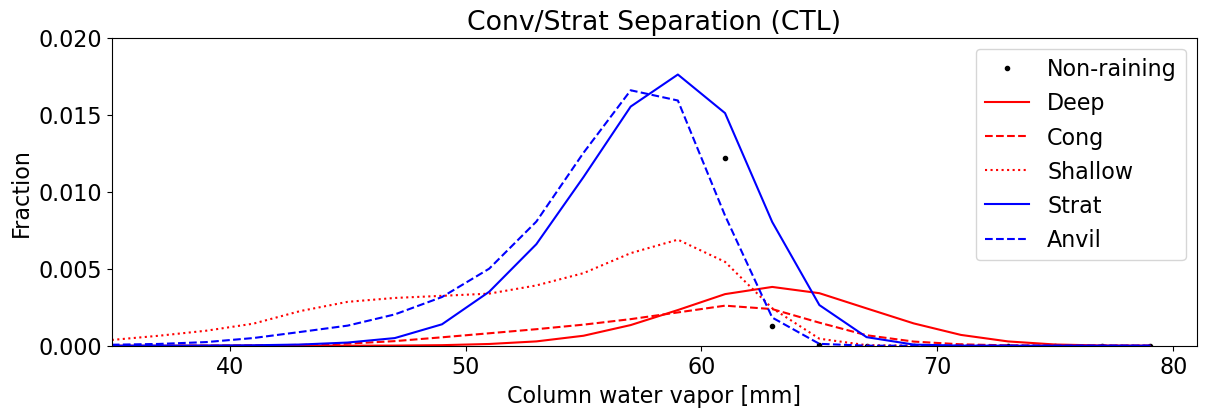

In [15]:
fig_title = 'Conv/Strat Separation ('+test_str.upper()+')'# ('+hr_tag+' h)'

# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

# As fraction of all-points-total
ax.set_ylabel('Fraction')
total=np.sum(strat_binned)

plt.plot(bins[0:nbins-1], strat_binned[:,0]/total \
        , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], strat_binned[:,1]/total \
        , "-r", label="Deep")
plt.plot(bins[0:nbins-1], strat_binned[:,2]/total \
        , "--r", label="Cong")
plt.plot(bins[0:nbins-1], strat_binned[:,3]/total \
        , ":r", label="Shallow")
plt.plot(bins[0:nbins-1], strat_binned[:,4]/total \
        , "-b", label="Strat")
plt.plot(bins[0:nbins-1], strat_binned[:,5]/total \
        , "--b", label="Anvil")

plt.xlim(np.min(bins), np.max(bins))
plt.ylim(0, 0.020)

#     ax.twinx()
#     plt.plot(bins[0:nbins-1], mselw_binned[ktest,:], "-k", label="HPLWP")

plt.legend(loc="upper right")

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

### LW ACRE

### LW ACRE by classification

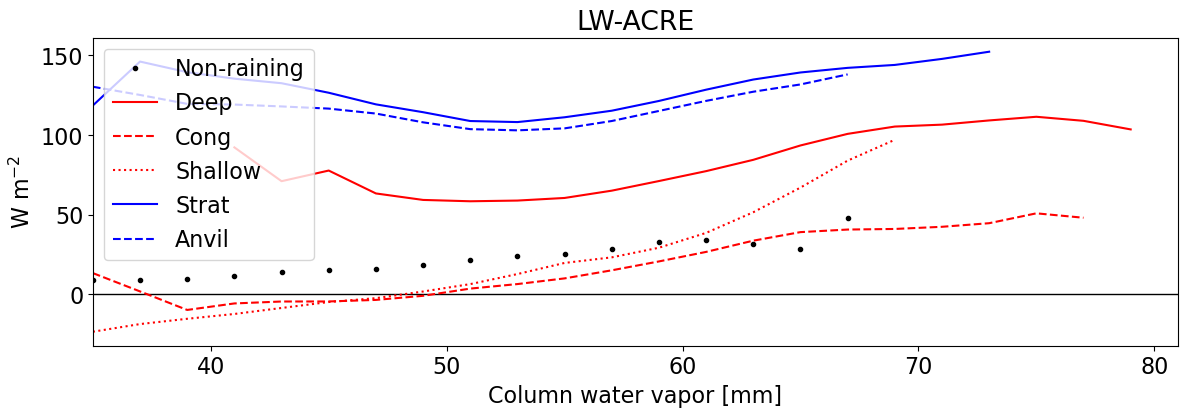

In [16]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacrestrat'
ytag='W m$^{-2}$'

ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)

# As fraction of all-rain-total
# total=np.sum(strat_binned[:,(1,2,3)])
# plt.plot(bins[0:nbins-1], var2d_binned_mn*strat_binned[:,0]/total \
#          , ".k", label="Non-raining")
# plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,1]/total \
#          , "-r", label="Conv")
# plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,2]/total \
#          , "-b", label="Strat")
# plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,3]/total \
#          , "--b", label="Other")
plt.plot(bins[0:nbins-1], lwacre_strat[:,0] \
        , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], lwacre_strat[:,1] \
        , "-r", label="Deep")
plt.plot(bins[0:nbins-1], lwacre_strat[:,2] \
        , "--r", label="Cong")
plt.plot(bins[0:nbins-1], lwacre_strat[:,3] \
        , ":r", label="Shallow")
plt.plot(bins[0:nbins-1], lwacre_strat[:,4] \
        , "-b", label="Strat")
plt.plot(bins[0:nbins-1], lwacre_strat[:,5] \
        , "--b", label="Anvil")

plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 10)

plt.legend(loc="upper left")

# plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)
plt.show()

### Weighted LW ACRE by classification

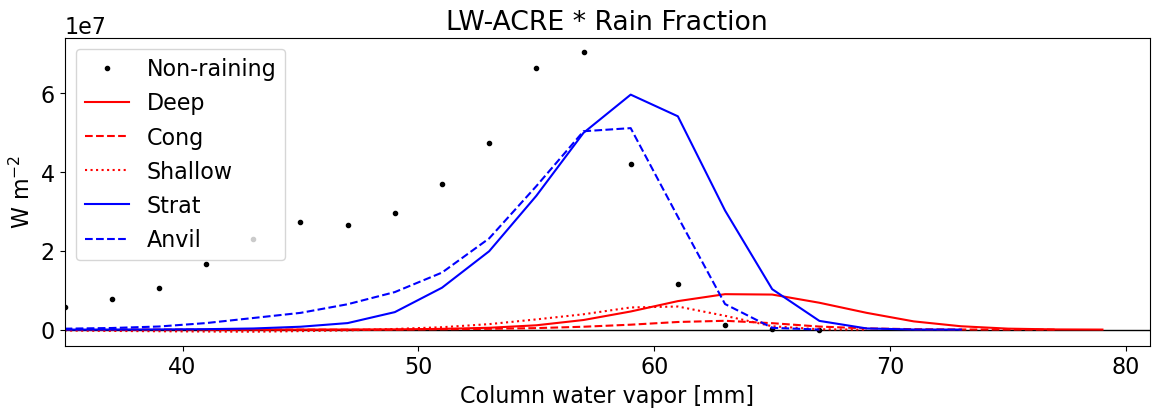

In [18]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacrestrat'
ytag='W m$^{-2}$'

ax.set_title('LW-ACRE * Rain Fraction')
# ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)

# As fraction of all-rain-total
total=np.sum(strat_binned)
fraction = strat_binned#/total

plt.plot(bins[0:nbins-1], lwacre_strat[:,0]*fraction[:,0] \
                , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], lwacre_strat[:,1]*fraction[:,1] \
                , "-r", label="Deep")
plt.plot(bins[0:nbins-1], lwacre_strat[:,2]*fraction[:,2] \
                , "--r", label="Cong")
plt.plot(bins[0:nbins-1], lwacre_strat[:,3]*fraction[:,3] \
                , ":r", label="Shallow")
plt.plot(bins[0:nbins-1], lwacre_strat[:,4]*fraction[:,4] \
                , "-b", label="Strat")
plt.plot(bins[0:nbins-1], lwacre_strat[:,5]*fraction[:,5] \
                , "--b", label="Anvil")

plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 10)

plt.legend(loc="upper left")

# plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
plt.show()